# Fraud Detection in Electricity and Gas Consumption

In [ ]:
!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mrmorj/fraud-detection-in-electricity-and-gas-consumption
from zipfile import ZipFile as zp
file_name = "fraud-detection-in-electricity-and-gas-consumption.zip"
with zp(file_name,'r') as z_p:
  z_p.extractall()
  print('Done.')

     |████████████████████████████████| 61kB 2.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=a986f01aea282d882b43509d658f7a896486b0fc0905e445a1ffe49204125b51
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Saving kaggle.json to kaggle.json
 75% 65.0M/87.2M [00:00<00:00, 56.7MB/s]
100% 87.2M/87.2M [00:00<00:00, 179MB/s] 
Done.


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import cm 
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from yellowbrick.target.feature_correlation import feature_correlation
from sklearn.model_selection import train_test_split
import imblearn
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported f

## Importing the Datasets.

In [ ]:
invoice_train = pd.read_csv(f'/content/invoice_train.csv',low_memory=False)
client_train = pd.read_csv(f'/content/client_train.csv',low_memory=False)
print("The shape of client_train: ",client_train.shape,"\n")
print("The shape of invoice_train: ",invoice_train.shape,"\n")

The shape of client_train:  (135493, 6) 

The shape of invoice_train:  (4476749, 16) 



In [ ]:
print('Client Dataset:\n')
print(client_train.describe())

Client Dataset:

             disrict    client_catg         region         target
count  135493.000000  135493.000000  135493.000000  135493.000000
mean       63.511222      11.512506     206.159809       0.055841
std         3.354400       4.423761     104.207044       0.229614
min        60.000000      11.000000     101.000000       0.000000
25%        62.000000      11.000000     103.000000       0.000000
50%        62.000000      11.000000     107.000000       0.000000
75%        69.000000      11.000000     307.000000       0.000000
max        69.000000      51.000000     399.000000       1.000000


In [ ]:

client_train.head().T

,0,1,2,3,4
disrict,60,69,62,69,62
client_id,train_Client_0,train_Client_1,train_Client_10,train_Client_100,train_Client_1000
client_catg,11,11,11,11,11
region,101,107,301,105,303
creation_date,31/12/1994,29/05/2002,13/03/1986,11/07/1996,14/10/2014
target,0,0,0,0,0


In [ ]:
invoice_train.head().T

,0,1,2,3,4
client_id,train_Client_0,train_Client_0,train_Client_0,train_Client_0,train_Client_0
invoice_date,2014-03-24,2013-03-29,2015-03-23,2015-07-13,2016-11-17
tarif_type,11,11,11,11,11
counter_number,1335667,1335667,1335667,1335667,1335667
counter_statue,0,0,0,0,0
counter_code,203,203,203,207,207
reading_remarque,8,6,8,8,9
counter_coefficient,1,1,1,1,1
consommation_level_1,82,1200,123,102,572
consommation_level_2,0,184,0,0,0


In [ ]:
invoice_train.describe().T

,count,mean,std,min,25%,50%,75%,max
tarif_type,4476749.0,2.012804e+01,1.347256e+01,8.0,11.0,11.0,40.0,4.500000e+01
counter_number,4476749.0,1.230587e+11,1.657267e+12,0.0,121108.0,494561.0,1115161.0,2.798115e+13
counter_code,4476749.0,1.724884e+02,1.338871e+02,0.0,5.0,203.0,207.0,6.000000e+02
reading_remarque,4476749.0,7.321702e+00,1.571654e+00,5.0,6.0,8.0,9.0,4.130000e+02
counter_coefficient,4476749.0,1.003040e+00,3.083466e-01,0.0,1.0,1.0,1.0,5.000000e+01
consommation_level_1,4476749.0,4.109795e+02,7.573080e+02,0.0,79.0,274.0,600.0,9.999100e+05
consommation_level_2,4476749.0,1.093225e+02,1.220123e+03,0.0,0.0,0.0,0.0,9.990730e+05
consommation_level_3,4476749.0,2.030620e+01,1.574239e+02,0.0,0.0,0.0,0.0,6.449200e+04
consommation_level_4,4476749.0,5.292588e+01,8.754725e+02,0.0,0.0,0.0,0.0,5.479460e+05
old_index,4476749.0,1.776700e+04,4.036693e+04,0.0,1791.0,7690.0,21660.0,2.800280e+06


In [ ]:
invoice_train.invoice_date.unique()

array(['2014-03-24', '2013-03-29', '2015-03-23', ..., '1995-11-28',
       '1982-07-04', '1996-09-02'], dtype=object)

## Checking NULL values

In [ ]:
print("Null values in client_train:",client_train.isna().sum().sum(),"\n")
print("Null values in invoice_train:",invoice_train.isna().sum().sum(),"\n")

Null values in client_train: 0 

Null values in invoice_train: 0 



## Checking Duplicates

In [ ]:
client_train.drop_duplicates(inplace = True)
print("The shape of client_train: ",client_train.shape,"\n")
invoice_train.drop_duplicates(inplace = True)
print("The shape of invoice_train: ",invoice_train.shape,"\n")

The shape of client_train:  (135493, 6) 

The shape of invoice_train:  (4476738, 16) 



## Displaying the datasets

In [ ]:
client_train.head(5)

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [ ]:
client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


In [ ]:
invoice_train.head(5)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [ ]:
invoice_train.describe().T

,count,mean,std,min,25%,50%,75%,max
tarif_type,4476738.0,2.012804e+01,1.347256e+01,8.0,11.0,11.0,40.0,4.500000e+01
counter_number,4476738.0,1.230590e+11,1.657269e+12,0.0,121108.0,494561.0,1115161.0,2.798115e+13
counter_code,4476738.0,1.724882e+02,1.338869e+02,0.0,5.0,203.0,207.0,6.000000e+02
reading_remarque,4476738.0,7.321705e+00,1.571655e+00,5.0,6.0,8.0,9.0,4.130000e+02
counter_coefficient,4476738.0,1.003040e+00,3.083470e-01,0.0,1.0,1.0,1.0,5.000000e+01
consommation_level_1,4476738.0,4.109805e+02,7.573087e+02,0.0,79.0,274.0,600.0,9.999100e+05
consommation_level_2,4476738.0,1.093227e+02,1.220125e+03,0.0,0.0,0.0,0.0,9.990730e+05
consommation_level_3,4476738.0,2.030625e+01,1.574241e+02,0.0,0.0,0.0,0.0,6.449200e+04
consommation_level_4,4476738.0,5.292601e+01,8.754735e+02,0.0,0.0,0.0,0.0,5.479460e+05
old_index,4476738.0,1.776701e+04,4.036695e+04,0.0,1791.0,7690.0,21660.0,2.800280e+06


## Merging the client and invoice dataset on client ID

In [ ]:
invoice_train_copy = invoice_train.copy()
merged_df = pd.merge(invoice_train_copy, client_train, on='client_id')
print("The shape of the merged dataframe:",merged_df.shape,"\n")
merged_df.head(5)

The shape of the merged dataframe: (4476738, 21) 



,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,disrict,client_catg,region,creation_date,target
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC,60,11,101,31/12/1994,0.0
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC,60,11,101,31/12/1994,0.0
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC,60,11,101,31/12/1994,0.0
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC,60,11,101,31/12/1994,0.0
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC,60,11,101,31/12/1994,0.0


In [ ]:
fraud = merged_df[merged_df.target==1.0].copy()

In [ ]:
fraud.invoice_date.value_counts()

2017-05-09    614
2017-03-05    565
2019-03-09    496
2017-02-08    489
2017-04-07    469
             ... 
2005-07-15      2
2005-07-22      2
2011-06-25      1
2011-01-14      1
2011-01-17      1
Name: invoice_date, Length: 3281, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc15526d7d0>,
      dtype=object)

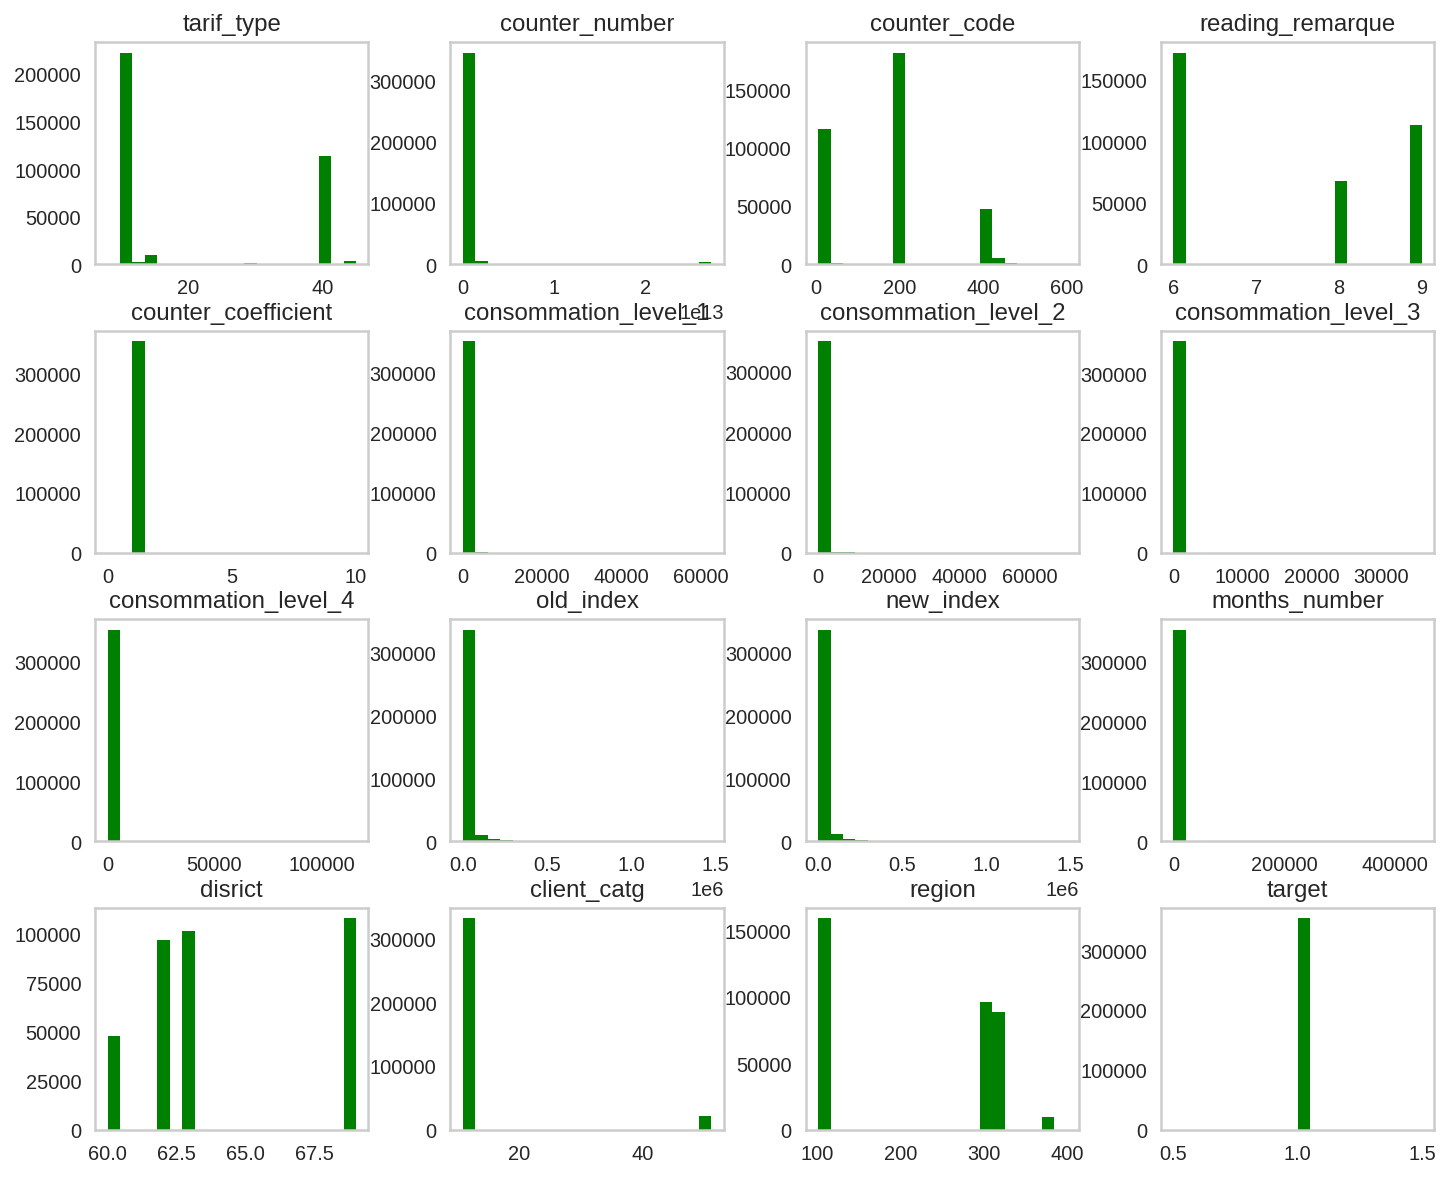

In [ ]:
fraud.hist(bins=20, color='green', grid=False, figsize=(12,10))

## Storing the target variable and dropping it from merged dataset

In [ ]:
merged_df_target = merged_df['target']
merged_df = merged_df.drop(columns=['target'])

## Checking for null values in merged dataset

In [ ]:
print("Number of null values in the merged df:", merged_df.isna().sum().sum())

Number of null values in the merged df: 0


## Describing merged dataset

In [ ]:
merged_df.describe().apply(lambda s: s.apply('{0:.3f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
tarif_type,4476738.000,20.128,13.473,8.000,11.000,11.000,40.000,45.000
counter_number,4476738.000,123059001435.461,1657269299110.165,0.000,121108.000,494561.000,1115161.000,27981145458733.000
counter_code,4476738.000,172.488,133.887,0.000,5.000,203.000,207.000,600.000
reading_remarque,4476738.000,7.322,1.572,5.000,6.000,8.000,9.000,413.000
counter_coefficient,4476738.000,1.003,0.308,0.000,1.000,1.000,1.000,50.000
consommation_level_1,4476738.000,410.981,757.309,0.000,79.000,274.000,600.000,999910.000
consommation_level_2,4476738.000,109.323,1220.125,0.000,0.000,0.000,0.000,999073.000
consommation_level_3,4476738.000,20.306,157.424,0.000,0.000,0.000,0.000,64492.000
consommation_level_4,4476738.000,52.926,875.474,0.000,0.000,0.000,0.000,547946.000
old_index,4476738.000,17767.007,40366.951,0.000,1791.000,7690.000,21660.000,2800280.000


## Number of unique values in merged dataset

In [ ]:
print('Number of unique values in merged_df:\n')
for col in merged_df.columns:
    print(f"{col} - {merged_df[col].nunique()}")

Number of unique values in merged_df:

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2
disrict - 4
client_catg - 3
region - 25
creation_date - 8088


## Unique values in merged dataset

In [ ]:
print('Unique values in merged_df:\n')
for col in merged_df.columns:
    print(f"{col} - {merged_df[col].unique()}\n")

Unique values in merged_df:

client_id - ['train_Client_0' 'train_Client_1' 'train_Client_10' ...
 'train_Client_99997' 'train_Client_99998' 'train_Client_99999']

invoice_date - ['2014-03-24' '2013-03-29' '2015-03-23' ... '1995-11-28' '1982-07-04'
 '1996-09-02']

tarif_type - [11 40 15 10 12 14 13 45 29  9 30  8 21 42 27 18 24]

counter_number - [1335667  678902  572765 ... 4811719  262195  560948]

counter_statue - ['0' '1' '5' '4' '3' '2' '769' 'A' '618' '269375' '46' '420']

counter_code - [203 207 413   5 467 202 420 410  10 483  25 433 407 204 214 442 453 506
 450 403 333 201 102 305 210 101 532  40 310 565 600 307 303 222  65   0
 227 325  16 317 367   1]

reading_remarque - [  8   6   9   7 207 413 203   5]

counter_coefficient - [ 1  3  0 10  4 33 50 20  2  6 40  9 30  5 11  8]

consommation_level_1 - [   82  1200   123 ... 43053  4824  8314]

consommation_level_2 - [    0   184   186 ... 46017 29019 32001]

consommation_level_3 - [   0  800   43 ... 1710 1750 1390]

consommat

## Feature Engineering and preprocessing data

In [ ]:
def preprocess_data(merged_df):
  merged_df['creation_date'] = pd.to_datetime(merged_df['creation_date'], dayfirst=True)
  merged_df['creation_month'] = merged_df['creation_date'].dt.month
  merged_df['creation_year'] = merged_df['creation_date'].dt.year
  print("Maximum value in creation_year column:\n",merged_df['creation_year'].unique().max())
  merged_df['acc_creation_time'] = (2019 - merged_df['creation_date'].dt.year)*12 - merged_df['creation_date'].dt.month # time in months since the creation of an account
  merged_df['invoice_date'] = pd.to_datetime(merged_df['invoice_date'], dayfirst=True)
  merged_df['invoice_month'] = merged_df['invoice_date'].dt.month
  merged_df['invoice_year'] = merged_df['invoice_date'].dt.year
  merged_df['change_in_index'] = merged_df['new_index'] - merged_df['old_index']
  merged_df['tarif_type'] = merged_df['tarif_type'].astype('category')
  merged_df['reading_remarque'] = merged_df['reading_remarque'].astype('category')
  merged_df['disrict'] = merged_df['disrict'].astype('category')
  merged_df['client_catg'] = merged_df['client_catg'].astype('category')
  merged_df['delta_time'] = merged_df.sort_values(['client_id','invoice_date']).groupby('client_id')['invoice_date'].diff().dt.days.reset_index(drop=True)
  print("\nNull values in delta_time: ", merged_df['delta_time'].isnull().sum()) # amount of time between invoices for each user
  merged_df['delta_time'] = merged_df['delta_time'].fillna(method='bfill')
  print("\nNull values in delta_time after imputation: ", merged_df['delta_time'].isnull().sum())
  merged_df['counter_statue'] = merged_df['counter_statue'].map({'0':0, '1':1, '2':2, '3':3, '4':4, '5':5, '769':5, 'A':0, '618':5, '269375':5, '46':5, '420':5}).astype('category')
  merged_df['counter_type'] = merged_df['counter_type'].map({'ELEC':0, 'GAZ':1}).astype('category')
  merged_df['counter_coefficient'] = merged_df['counter_coefficient'].map({0:1, 1:1, 2:2, 3:3, 4:4, 40:4, 30:4, 6:4, 10:4, 20:4, 9:4, 11:4, 50:4, 33:4, 8:4, 5:4}).astype('category')
  merged_df['consommation_levels_mean'] = merged_df.loc[:, 'consommation_level_1':'consommation_level_4'].mean(axis=1).reset_index(drop=True)
  return merged_df

In [ ]:
merged_df = preprocess_data(merged_df)

Maximum value in creation_year column:
 2019

Null values in delta_time:  135493

Null values in delta_time after imputation:  0


In [ ]:
set(merged_df.invoice_year.unique())

In [ ]:
merged_df.head(5)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,disrict,client_catg,region,creation_date,creation_month,creation_year,acc_creation_time,invoice_month,invoice_year,change_in_index,delta_time,consommation_levels_mean
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,0,60,11,101,1994-12-31,12,1994,288,3,2014,82,130.0,20.50
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,0,60,11,101,1994-12-31,12,1994,288,3,2013,1384,130.0,346.00
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,0,60,11,101,1994-12-31,12,1994,288,3,2015,123,119.0,30.75
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,0,60,11,101,1994-12-31,12,1994,288,7,2015,102,117.0,25.50
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,0,60,11,101,1994-12-31,12,1994,288,11,2016,572,131.0,143.00


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4476738 entries, 0 to 4476737
Data columns (total 28 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   client_id                 object        
 1   invoice_date              datetime64[ns]
 2   tarif_type                category      
 3   counter_number            int64         
 4   counter_statue            category      
 5   counter_code              int64         
 6   reading_remarque          category      
 7   counter_coefficient       category      
 8   consommation_level_1      int64         
 9   consommation_level_2      int64         
 10  consommation_level_3      int64         
 11  consommation_level_4      int64         
 12  old_index                 int64         
 13  new_index                 int64         
 14  months_number             int64         
 15  counter_type              category      
 16  disrict                   category      
 17  client_c

In [ ]:
# merged_df[merged_df.target]

## Dropping creation_date & invoice_date columns.

In [ ]:
print("Shape before dropping columns:", merged_df.shape)
merged_df.drop(['creation_date','invoice_date'], axis=1, inplace=True)
print("Shape after dropping columns:", merged_df.shape)

Shape before dropping columns: (4476738, 28)
Shape after dropping columns: (4476738, 26)


## Final dataset after cleaning

In [ ]:
final_df = pd.concat([merged_df, merged_df_target], axis = 1)
final_df.head(10)

,client_id,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,disrict,client_catg,region,creation_month,creation_year,acc_creation_time,invoice_month,invoice_year,change_in_index,delta_time,consommation_levels_mean,target
0,train_Client_0,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,0,60,11,101,12,1994,288,3,2014,82,130.0,20.50,0.0
1,train_Client_0,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,0,60,11,101,12,1994,288,3,2013,1384,130.0,346.00,0.0
2,train_Client_0,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,0,60,11,101,12,1994,288,3,2015,123,119.0,30.75,0.0
3,train_Client_0,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,0,60,11,101,12,1994,288,7,2015,102,117.0,25.50,0.0
4,train_Client_0,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,0,60,11,101,12,1994,288,11,2016,572,131.0,143.00,0.0
5,train_Client_0,11,1335667,0,207,9,1,314,0,0,0,15638,15952,8,0,60,11,101,12,1994,288,7,2017,314,121.0,78.50,0.0
6,train_Client_0,11,1335667,0,207,9,1,541,0,0,0,15952,16493,12,0,60,11,101,12,1994,288,12,2018,541,120.0,135.25,0.0
7,train_Client_0,11,1335667,0,207,9,1,585,0,0,0,16493,17078,8,0,60,11,101,12,1994,288,3,2019,585,71.0,146.25,0.0
8,train_Client_0,11,1335667,0,203,9,1,1200,186,0,0,7770,9156,4,0,60,11,101,12,1994,288,7,2011,1386,206.0,346.50,0.0
9,train_Client_0,11,1335667,0,203,6,1,1082,0,0,0,9156,10238,4,0,60,11,101,12,1994,288,11,2011,1082,120.0,270.50,0.0


## Heatmap

In [ ]:
plt.figure(figsize=(25, 10))
g_1 = sns.heatmap(final_df.corr(), annot = True)

## Important Features

In [ ]:
from sklearn.preprocessing import LabelEncoder

final_df_target = final_df['target']
final_df_features = merged_df
le = LabelEncoder()
for i in final_df_features.columns:
    if final_df_features[i].dtype != 'int64' or final_df_features[i].dtype != 'float64':
        final_df_features[i] = le.fit_transform(final_df_features[i])

In [ ]:
visualizer = feature_correlation(merged_df, merged_df_target)
plt.tight_layout()

## Target class Imbalance

In [ ]:
g_2 = sns.histplot(data=final_df, x="target")

## Basic Visualization

In [ ]:
for col in ['disrict','region','client_catg']:
    ds = final_df.groupby([col])['client_id'].count()
    plt.bar(x = ds.index, height = ds.values)
    plt.title(col+' distribution')
    plt.show()

In [ ]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [ ]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) 
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] 
    columnNames = list(df)
    if len(columnNames) > 10: 
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [ ]:
plotScatterMatrix(client_train, 12, 10)

In [ ]:
plotPerColumnDistribution(invoice_train_copy, 10, 5)

In [ ]:
# plotScatterMatrix(invoice_train_copy, 12, 10)

## Dropping columns that are less important

In [ ]:
final_df = final_df.drop(labels=['client_id','invoice_year','creation_month','months_number','counter_code','new_index'],axis=1)

## Defining X and Y

In [ ]:
X = final_df.iloc[:,:-1]
y = final_df['target']

In [ ]:
print("The shape of X: ",X.shape)
print("The shape of Y:",y.shape)

The shape of X:  (4476738, 26)
The shape of Y: (4476738,)


In [ ]:
X.head()

In [ ]:
y.head()

## Random Under Sampling: Balancing the dataset

### Implementing Logistic Regression, Linear SVM, Random Forest, XGBoost Classification, CatBoost Classification.

In [ ]:
rus = RandomUnderSampler(random_state=42, replacement=True)
x_rus, y_rus = rus.fit_resample(X, y)
print('Original dataset shape:', Counter(y))
print('Resample dataset shape:', Counter(y_rus))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Original dataset shape: Counter({0.0: 4123629, 1.0: 353109})
Resample dataset shape: Counter({0.0: 353109, 1.0: 353109})


Text(0.5, 1.0, 'Before under sampling:')

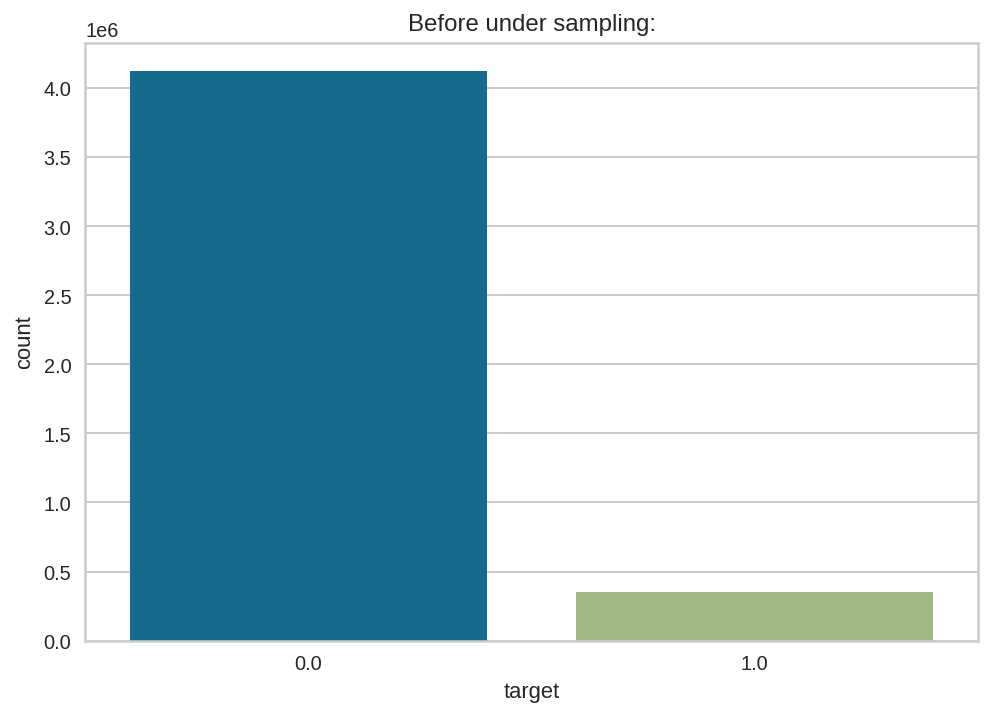

In [ ]:
sns.countplot(x=y).set_title('Before under sampling:')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'After Under Sampling:')

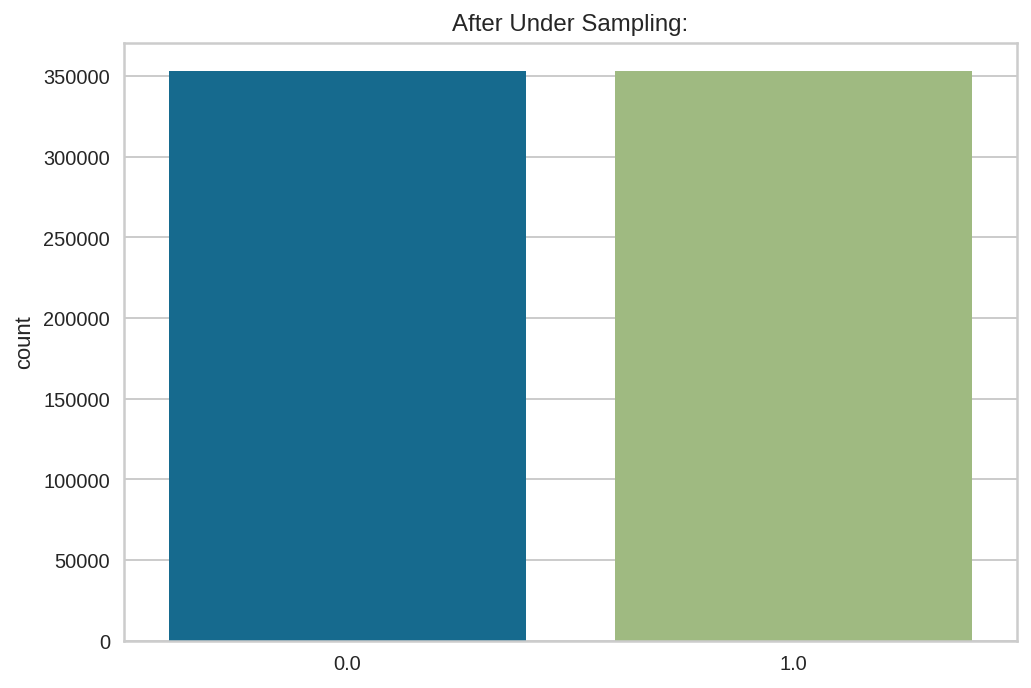

In [ ]:
sns.countplot(y_rus).set_title('After Under Sampling:')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Original dataset shape: Counter({0.0: 4123629, 1.0: 353109})
Resample dataset shape: Counter({0.0: 353109, 1.0: 353109})
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Train Accuracy: 0.5916767851263952 

Test Accuracy: 59.16357508991532%

              precision    recall  f1-score   support

         0.0       0.59      0.59      0.59     70165
         1.0       0.60      0.59      0.59     71079

    accuracy                           0.59    141244
   macro avg       0.59      0.59      0.59    141244
weighted avg       0.59      0.59      0.59    141244
 



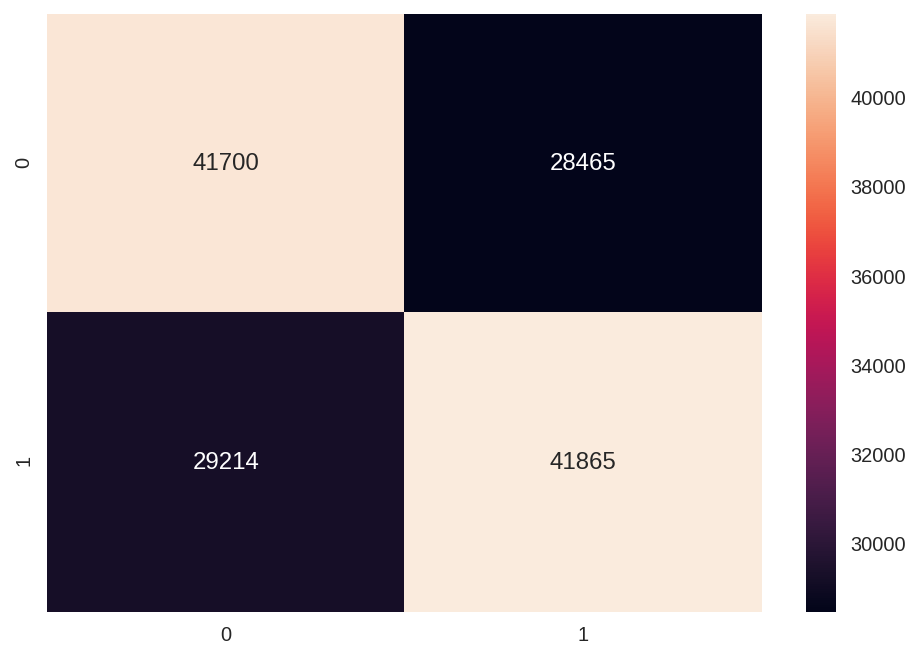

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Train Accuracy: 0.591878564323314 

Test Accuracy: 59.20534677579224%

              precision    recall  f1-score   support

         0.0       0.59      0.60      0.59     70165
         1.0       0.60      0.59      0.59     71079

    accuracy                           0.59    141244
   macro avg       0.59      0.59      0.59    141244
weighted avg       0.59      0.59      0.59    141244
 



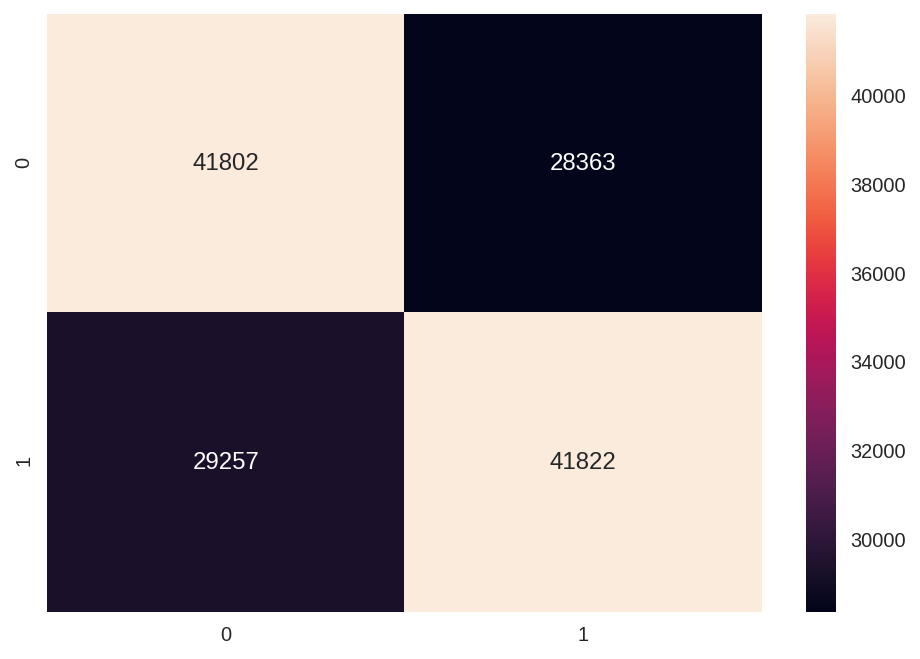

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
Train Accuracy: 0.9993132427332939 

Test Accuracy: 77.99835745235197%

              precision    recall  f1-score   support

         0.0       0.78      0.77      0.78     70165
         1.0       0.78      0.79      0.78     71079

    accuracy                           0.78    141244
   macro avg       0.78      0.78      0.78    141244
weighted avg       0.78      0.78      0.78    141244
 



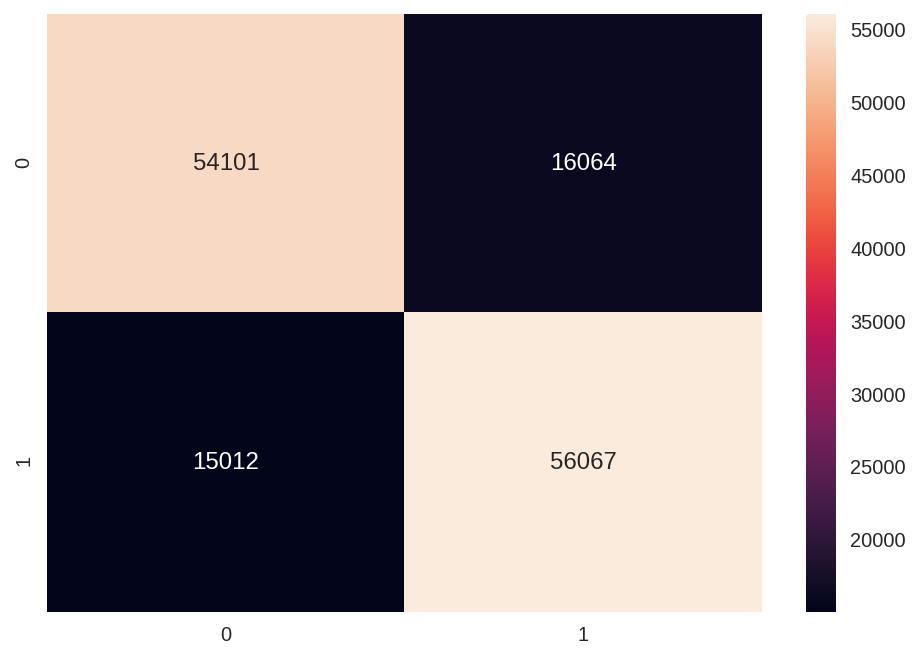

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Train Accuracy: 0.632915850994913 

Test Accuracy: 63.21542861997678%

              precision    recall  f1-score   support

         0.0       0.64      0.61      0.62     70165
         1.0       0.63      0.65      0.64     71079

    accuracy                           0.63    141244
   macro avg       0.63      0.63      0.63    141244
weighted avg       0.63      0.63      0.63    141244
 



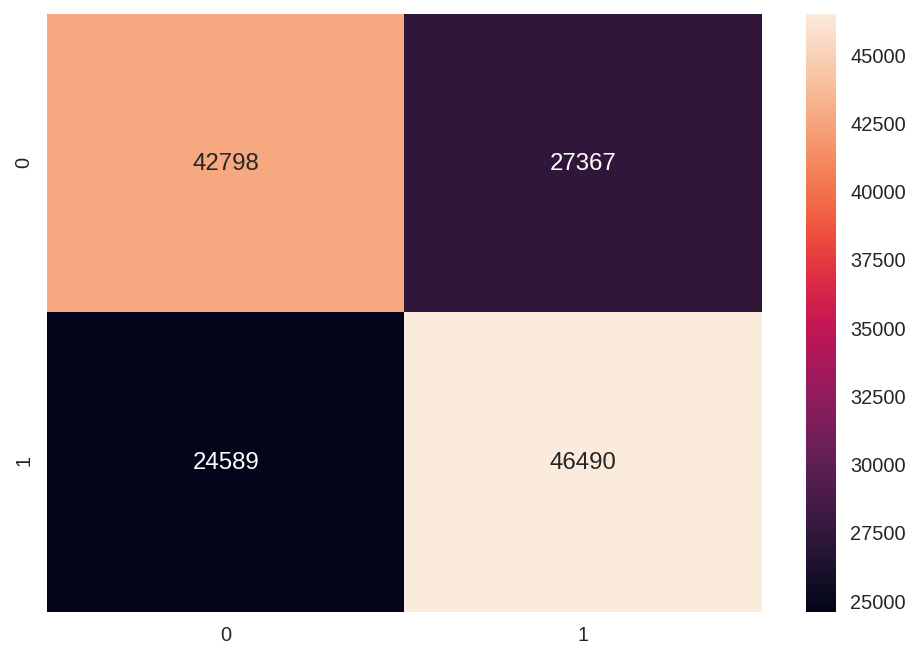

In [ ]:

xtrain, xtest, ytrain, ytest = train_test_split(x_rus, y_rus, random_state=1, test_size=0.2)
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)
def model(clf):
  clf.fit(xtrain, ytrain)
  print("Train Accuracy:", clf.score(xtrain, ytrain),"\n")
  y_pred = clf.predict(xtest)
  return y_pred
lr = LogisticRegression(random_state=1,max_iter=100)
svc = LinearSVC(random_state=1)
rfc = RandomForestClassifier(n_estimators=200,random_state=1)
xgb_c = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
models = [lr,svc,rfc,xgb_c]

for i in range(len(models)):
    print(models[i])
    y_pred = model(models[i])
    acc = accuracy_score(ytest, y_pred)*100
    print(f"Test Accuracy: {acc}%")
    print()
    print(classification_report(ytest, y_pred),"\n")
    
    cm = confusion_matrix(ytest, y_pred)
    g = sns.heatmap(cm, annot=True, fmt='g')
    plt.show()
    

In [ ]:
!pip3 install catboost
from catboost import CatBoostClassifier, Pool

print(final_df.info(),"\n")
category_cols = list(final_df.select_dtypes('category').columns)
final_df[category_cols].head(10)
print(category_cols,"\n")
columns = list(final_df.columns)
del columns[-1]
columns
cb_train = pd.DataFrame(xtrain, columns = columns)
cb_test = pd.DataFrame(xtest, columns=columns)
cb_train[category_cols] = cb_train[category_cols].astype(np.int8)
cb_train[category_cols] = cb_train[category_cols].astype('category')
cb_test[category_cols] = cb_test[category_cols].astype(np.int8)
cb_test[category_cols] = cb_test[category_cols].astype('category')
print(cb_test.info(),"\n")
cb_ytrain = ytrain.astype('int8')
cb_ytest = ytest.astype('int8')
train_data = Pool(cb_train, cb_ytrain, cat_features=category_cols)
test_data = Pool(cb_test, cb_ytest, cat_features=category_cols)
def train_and_predict(clf, train, test, labels=None):
  clf.fit(train, labels)
  y_pred = clf.predict(test)
  return y_pred

def plot_results(y_pred, test, labels, clf):
  print('Confusion Matrix:\n')
  clf_cm = confusion_matrix(labels, y_pred)
  clf_hm = sns.heatmap(clf_cm,annot=True,fmt='g',cmap="Blues")
  print('Classification Report:\n')
  class_report = classification_report(labels, y_pred)
  print(class_report)
cb_clf = CatBoostClassifier(random_seed=1,task_type='GPU',depth=10, eval_metric='Accuracy',learning_rate=0.05)
cb_clf_pred = train_and_predict(cb_clf, train_data, test_data)
plot_results(y_pred=cb_clf_pred, test=cb_test, labels=cb_ytest, clf=cb_clf)

## NearMiss: Balancing the dataset

### Implementing Logistic Regression, Linear SVM, Random Forest, XGBoost Classification, CatBoost Classification.

In [ ]:
X.drop('client_id', axis=1, inplace=True)

In [ ]:
from imblearn.under_sampling import NearMiss

nm = NearMiss()
x_nm, y_nm = nm.fit_resample(X, y)
print('Original dataset shape:', Counter(y))
print('Resample dataset shape:', Counter(y_nm))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Original dataset shape: Counter({0.0: 4123629, 1.0: 353109})
Resample dataset shape: Counter({0.0: 353109, 1.0: 353109})


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Before Near Miss:')

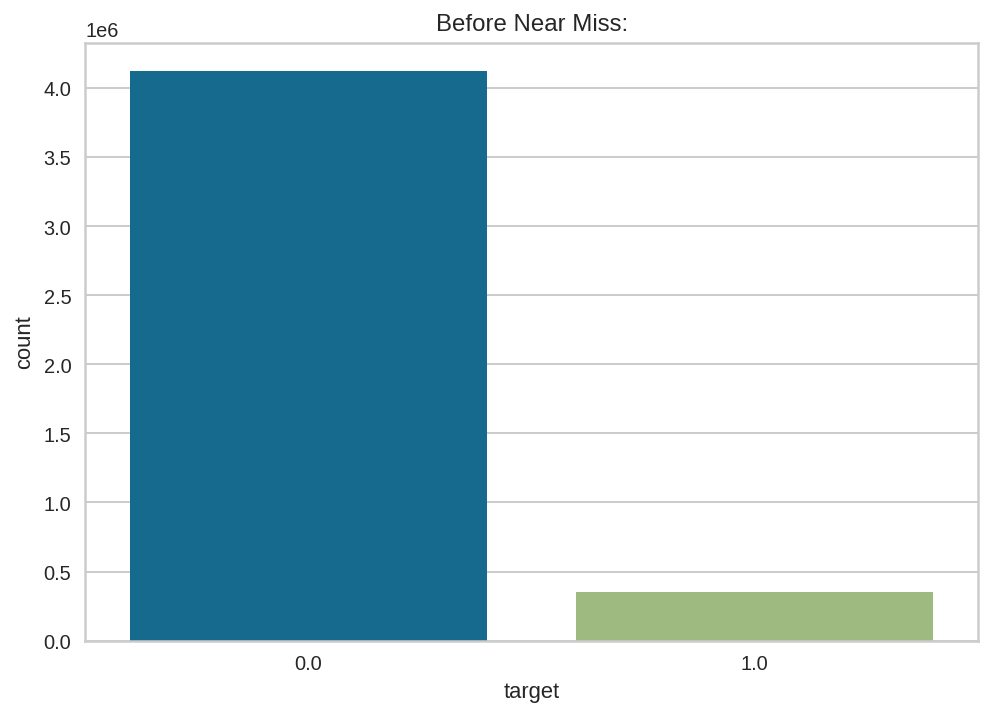

In [ ]:
sns.countplot(y).set_title('Before Near Miss:')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'After applying Near Miss:')

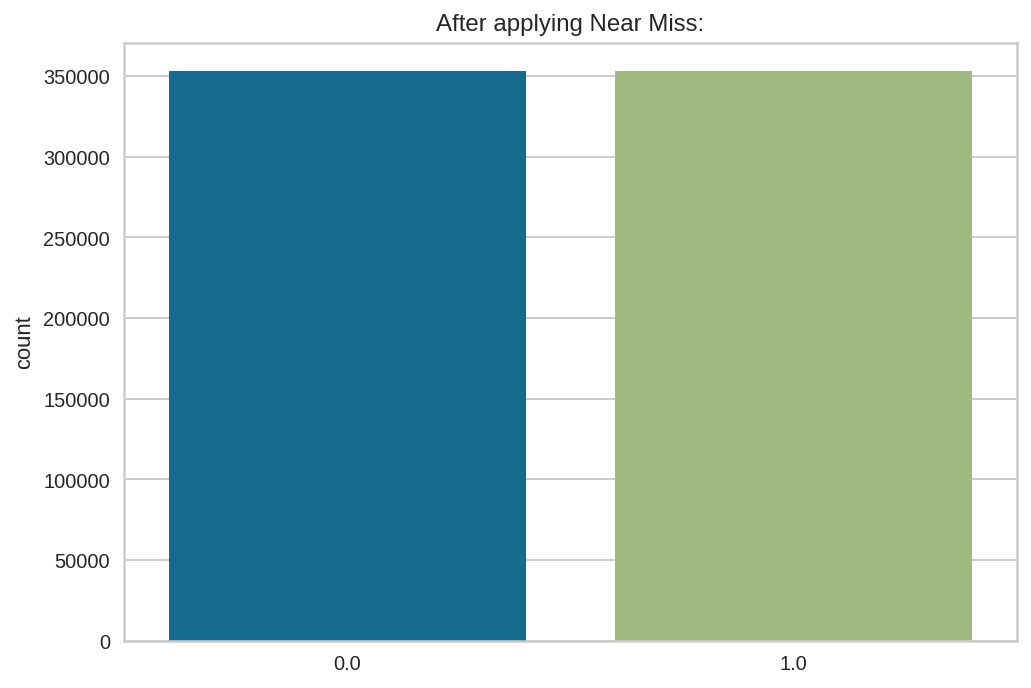

In [ ]:
sns.countplot(y_nm).set_title('After applying Near Miss:')

In [ ]:
X.head()

,client_id,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,disrict,client_catg,region,creation_month,creation_year,acc_creation_time,invoice_month,invoice_year,change_in_index,delta_time,consommation_levels_mean
0,train_Client_0,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,0,60,11,101,12,1994,288,3,2014,82,130.0,20.50
1,train_Client_0,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,0,60,11,101,12,1994,288,3,2013,1384,130.0,346.00
2,train_Client_0,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,0,60,11,101,12,1994,288,3,2015,123,119.0,30.75
3,train_Client_0,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,0,60,11,101,12,1994,288,7,2015,102,117.0,25.50
4,train_Client_0,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,0,60,11,101,12,1994,288,11,2016,572,131.0,143.00


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Original dataset shape: Counter({0.0: 4123629, 1.0: 353109})
Resample dataset shape: Counter({0.0: 353109, 1.0: 353109})
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train Accuracy: 0.8554942351329442 

              precision    recall  f1-score   support

         0.0       0.80      0.95      0.87     70165
         1.0       0.94      0.76      0.84     71079

    accuracy                           0.85    141244
   macro avg       0.87      0.86      0.85    141244
weighted avg       0.87      0.85      0.85    141244
 

Test Accuracy: 85.45495737872051%


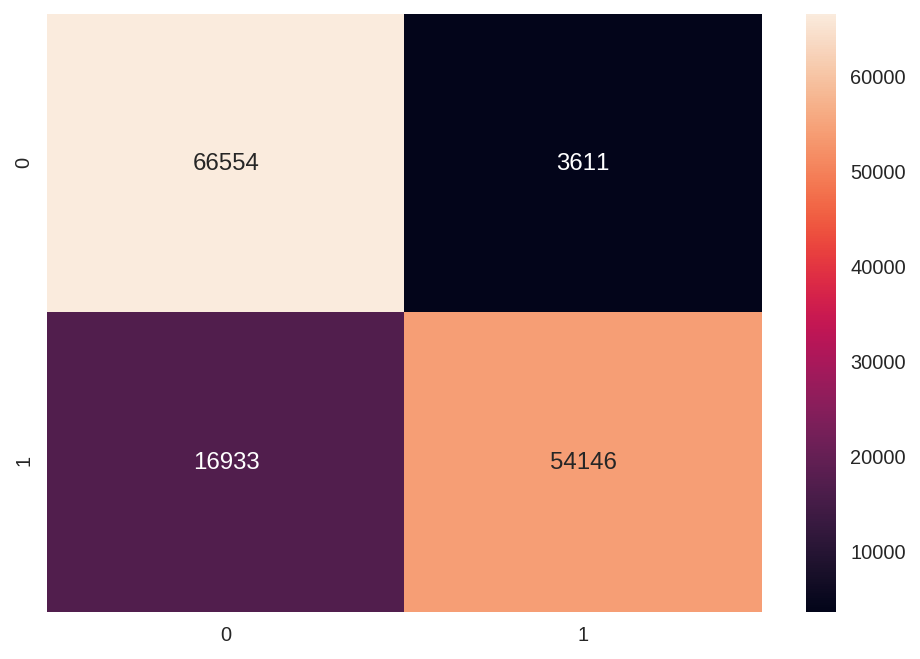


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Train Accuracy: 0.8526533964394821 

              precision    recall  f1-score   support

         0.0       0.79      0.96      0.87     70165
         1.0       0.95      0.75      0.84     71079

    accuracy                           0.85    141244
   macro avg       0.87      0.85      0.85    141244
weighted avg       0.87      0.85      0.85    141244
 

Test Accuracy: 85.20149528475545%


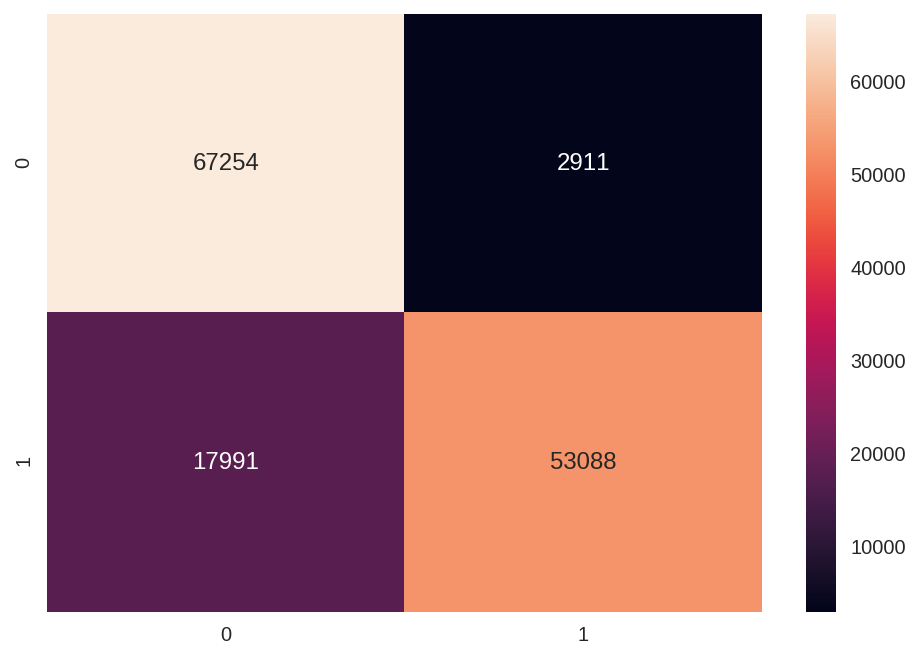


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
Train Accuracy: 0.9966600232931073 

              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90     70165
         1.0       0.94      0.85      0.89     71079

    accuracy                           0.90    141244
   macro avg       0.90      0.90      0.90    141244
weighted avg       0.90      0.90      0.90    141244
 

Test Accuracy: 89.5230947863272%


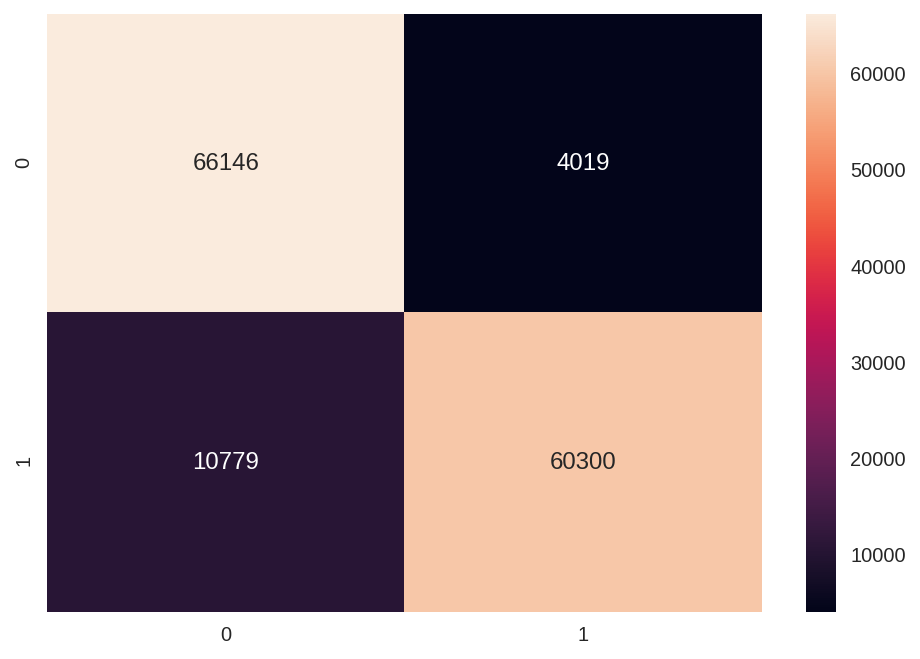


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Train Accuracy: 0.857147408553314 

              precision    recall  f1-score   support

         0.0       0.80      0.95      0.87     70165
         1.0       0.94      0.77      0.84     71079

    accuracy                           0.86    141244
   macro avg       0.87      0.86      0.86    141244
weighted avg       0.87      0.86      0.86    141244
 

Test Accuracy: 85.61921214352468%


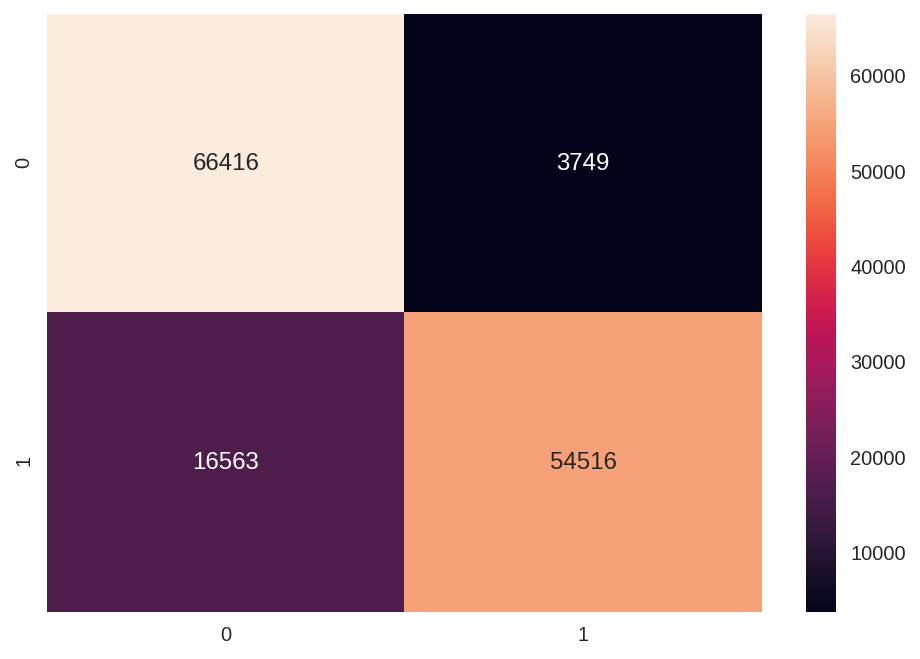

In [ ]:
from imblearn.under_sampling import NearMiss

nm = NearMiss()
x_nm, y_nm = nm.fit_resample(X, y)
print('Original dataset shape:', Counter(y))
print('Resample dataset shape:', Counter(y_nm))

X_train, X_test, y_train, y_test = train_test_split(x_nm, y_nm, random_state=1, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
def model(clf):
  clf.fit(X_train, y_train)
  print("Train Accuracy:", clf.score(X_train, y_train),"\n")
  y_pred_nm = clf.predict(X_test)
  return y_pred_nm
lr = LogisticRegression(random_state=1,max_iter=100)
svc = LinearSVC(random_state=1)
rfc = RandomForestClassifier(n_estimators=200,random_state=1)
xgb_c = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
models = [lr,svc,rfc,xgb_c]

for i in range(len(models)):
    print(models[i])
    y_pred_nm = model(models[i])
    print(classification_report(y_test, y_pred_nm),"\n")
    acc = accuracy_score(y_test, y_pred_nm)*100
    print(f"Test Accuracy: {acc}%")
    cm = confusion_matrix(y_test, y_pred_nm)
    g = sns.heatmap(cm, annot=True, fmt='g')
    plt.show()
    print()
    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4476738 entries, 0 to 4476737
Data columns (total 21 columns):
 #   Column                    Dtype   
---  ------                    -----   
 0   tarif_type                category
 1   counter_number            int64   
 2   counter_statue            category
 3   reading_remarque          category
 4   counter_coefficient       category
 5   consommation_level_1      int64   
 6   consommation_level_2      int64   
 7   consommation_level_3      int64   
 8   consommation_level_4      int64   
 9   old_index                 int64   
 10  counter_type              category
 11  disrict                   category
 12  client_catg               category
 13  region                    int64   
 14  creation_year             int64   
 15  acc_creation_time         int64   
 16  invoice_month             int64   
 17  change_in_index           int64   
 18  delta_time                float64 
 19  consommation_levels_mean  float64 
 20  ta

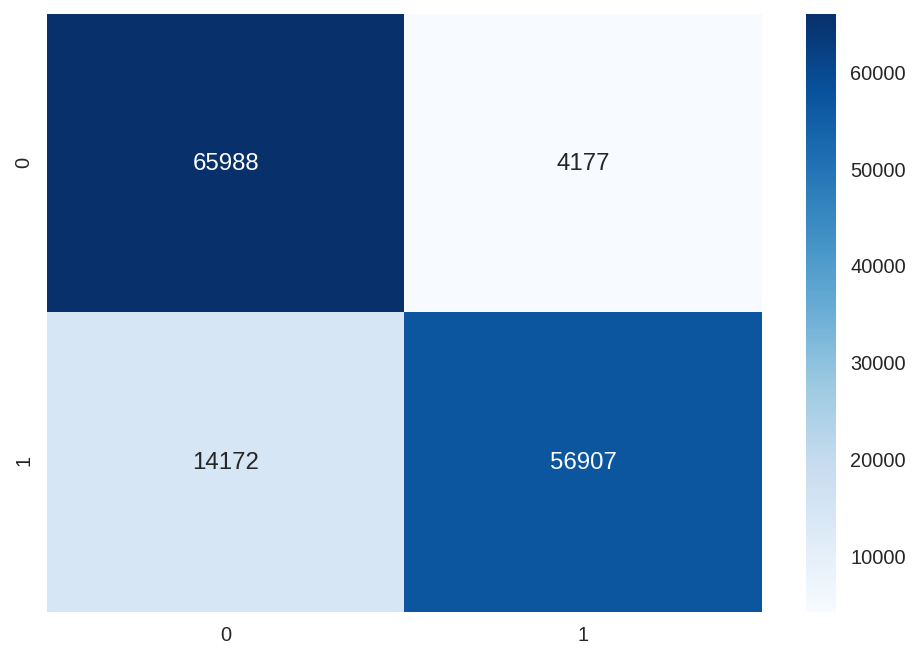

In [ ]:
from catboost import CatBoostClassifier, Pool

print(final_df.info(),"\n")
category_cols_1 = list(final_df.select_dtypes('category').columns)
final_df[category_cols_1].head(10)
print(category_cols_1,"\n")
columns_1 = list(final_df.columns)
del columns_1[-1]
print(columns_1)
cb_train = pd.DataFrame(X_train, columns = columns_1)
cb_test = pd.DataFrame(X_test, columns=columns)
cb_train[category_cols] = cb_train[category_cols].astype(np.int8)
cb_train[category_cols] = cb_train[category_cols].astype('category')
cb_test[category_cols] = cb_test[category_cols].astype(np.int8)
cb_test[category_cols] = cb_test[category_cols].astype('category')
print(cb_test.info(),"\n")
cb_ytrain = y_train.astype('int8')
cb_ytest = y_test.astype('int8')
train_data = Pool(cb_train, cb_ytrain, cat_features=category_cols_1)
test_data = Pool(cb_test, cb_ytest, cat_features=category_cols_1)
def train_and_predict(clf, train, test, labels=None):
  clf.fit(train, labels)
  y_pred = clf.predict(test)
  return y_pred

def plot_results(y_pred, test, labels, clf):
  print('Confusion Matrix:\n')
  clf_cm = confusion_matrix(labels, y_pred)
  clf_hm = sns.heatmap(clf_cm,annot=True,fmt='g',cmap="Blues")
  print('Classification Report:\n')
  class_report = classification_report(labels, y_pred)
  print(class_report)
cb_clf = CatBoostClassifier(random_seed=1,task_type='GPU',depth=10, eval_metric='Accuracy',learning_rate=0.05)
cb_clf_pred = train_and_predict(cb_clf, train_data, test_data)
plot_results(y_pred=cb_clf_pred, test=cb_test, labels=cb_ytest, clf=cb_clf)